In [1]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

(957, 720)


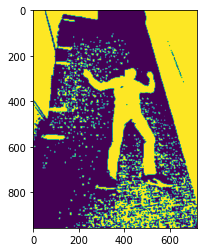

In [3]:
image = plt.imread('processing/gauss_processed.jpg')
print(image.shape)
plt.imshow(image)

In [4]:
gray = rgb2gray(image)
plt.imshow(gray, cmap='gray')

ValueError: the input array must have size 3 along `channel_axis`, got (957, 720)

In [6]:
gray_r = image
# gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

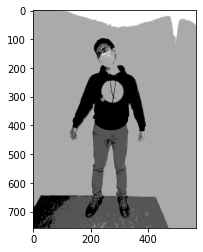

In [75]:
gray = rgb2gray(image)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 3
    elif gray_r[i] > 0.5:
        gray_r[i] = 2
    elif gray_r[i] > 0.25:
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

(757, 567)


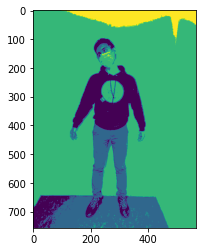

In [76]:
if len(gray.shape) > 2 and gray.shape[2] == 4:
    #convert the image from RGBA2RGB
    gray = cv2.cvtColor(gray, cv2.COLOR_BGRA2BGR)
print(gray.shape)
plt.imshow(gray)

In [8]:
# converting to grayscale
# gray = rgb2gray(image)

# defining the sobel filters
sobel_horizontal = np.array([np.array([1, 2, 1]), np.array([0, 0, 0]), np.array([-1, -2, -1])])
print(sobel_horizontal, 'is a kernel for detecting horizontal edges')
 
sobel_vertical = np.array([np.array([-1, 0, 1]), np.array([-2, 0, 2]), np.array([-1, 0, 1])])
print(sobel_vertical, 'is a kernel for detecting vertical edges')

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]] is a kernel for detecting horizontal edges
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]] is a kernel for detecting vertical edges


In [10]:
out_h = ndimage.convolve(image, sobel_horizontal, mode='reflect')
out_v = ndimage.convolve(image, sobel_vertical, mode='reflect')
# here mode determines how the input array is extended when the filter overlaps a border.


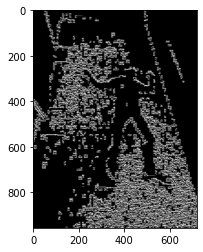

In [11]:
plt.imshow(out_h, cmap='gray')

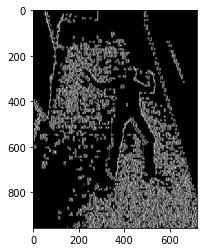

In [12]:
plt.imshow(out_v, cmap='gray')

In [13]:
kernel_laplace = np.array([np.array([1, 1, 1]), np.array([1, -8, 1]), np.array([1, 1, 1])])
out_l = ndimage.convolve(gray, kernel_laplace)
plt.imshow(out_l, cmap='gray')

NameError: name 'gray' is not defined

In [14]:
pic = plt.imread('paras-background.jpg')/255  # dividing by 255 to bring the pixel values between 0 and 1
print(pic.shape)
plt.imshow(pic)

FileNotFoundError: [Errno 2] No such file or directory: 'paras-background.jpg'

In [87]:
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape

(429219, 3)

In [88]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

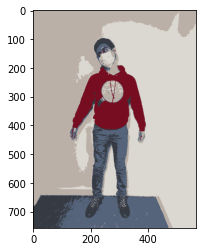

In [89]:
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic)

In [15]:
import tensorflow as tf

In [16]:
def load_vgg(sess, vgg_path):
  
  # load the model and weights
  model = tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)

  # Get Tensors to be returned from graph
  graph = tf.get_default_graph()
  image_input = graph.get_tensor_by_name('image_input:0')
  keep_prob = graph.get_tensor_by_name('keep_prob:0')
  layer3 = graph.get_tensor_by_name('layer3_out:0')
  layer4 = graph.get_tensor_by_name('layer4_out:0')
  layer7 = graph.get_tensor_by_name('layer7_out:0')

  return image_input, keep_prob, layer3, layer4, layer7

In [17]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
   
    # Use a shorter variable name for simplicity
    layer3, layer4, layer7 = vgg_layer3_out, vgg_layer4_out, vgg_layer7_out

    # Apply 1x1 convolution in place of fully connected layer
    fcn8 = tf.layers.conv2d(layer7, filters=num_classes, kernel_size=1, name="fcn8")

    # Upsample fcn8 with size depth=(4096?) to match size of layer 4 so that we can add skip connection with 4th layer
    fcn9 = tf.layers.conv2d_transpose(fcn8, filters=layer4.get_shape().as_list()[-1],
    kernel_size=4, strides=(2, 2), padding='SAME', name="fcn9")

    # Add a skip connection between current final layer fcn8 and 4th layer
    fcn9_skip_connected = tf.add(fcn9, layer4, name="fcn9_plus_vgg_layer4")

    # Upsample again
    fcn10 = tf.layers.conv2d_transpose(fcn9_skip_connected, filters=layer3.get_shape().as_list()[-1],
    kernel_size=4, strides=(2, 2), padding='SAME', name="fcn10_conv2d")

    # Add skip connection
    fcn10_skip_connected = tf.add(fcn10, layer3, name="fcn10_plus_vgg_layer3")

    # Upsample again
    fcn11 = tf.layers.conv2d_transpose(fcn10_skip_connected, filters=num_classes,
    kernel_size=16, strides=(8, 8), padding='SAME', name="fcn11")

    return fcn11

In [18]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
  
  # Reshape 4D tensors to 2D, each row represents a pixel, each column a class
  logits = tf.reshape(nn_last_layer, (-1, num_classes), name="fcn_logits")
  correct_label_reshaped = tf.reshape(correct_label, (-1, num_classes))

  # Calculate distance from actual labels using cross entropy
  cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label_reshaped[:])
  # Take mean for total loss
  loss_op = tf.reduce_mean(cross_entropy, name="fcn_loss")

  # The model implements this operation to find the weights/parameters that would yield correct pixel labels
  train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_op, name="fcn_train_op")

  return logits, train_op, loss_op

In [19]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op,
             cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):

  keep_prob_value = 0.5
  learning_rate_value = 0.001
  for epoch in range(epochs):
      # Create function to get batches
      total_loss = 0
      for X_batch, gt_batch in get_batches_fn(batch_size):

          loss, _ = sess.run([cross_entropy_loss, train_op],
          feed_dict={input_image: X_batch, correct_label: gt_batch,
          keep_prob: keep_prob_value, learning_rate:learning_rate_value})

          total_loss += loss;

      print("EPOCH {} ...".format(epoch + 1))
      print("Loss = {:.3f}".format(total_loss))
      print()

In [20]:
def run():
  
  # Download pretrained vgg model
  helper.maybe_download_pretrained_vgg(data_dir)

  # A function to get batches
  get_batches_fn = helper.gen_batch_function(training_dir, image_shape)
  
  with tf.Session() as session:
        
    # Returns the three layers, keep probability and input layer from the vgg architecture
    image_input, keep_prob, layer3, layer4, layer7 = load_vgg(session, vgg_path)

    # The resulting network architecture from adding a decoder on top of the given vgg model
    model_output = layers(layer3, layer4, layer7, num_classes)

    # Returns the output logits, training operation and cost operation to be used
    # - logits: each row represents a pixel, each column a class
    # - train_op: function used to get the right parameters to the model to correctly label the pixels
    # - cross_entropy_loss: function outputting the cost which we are minimizing, lower cost should yield higher accuracy
    logits, train_op, cross_entropy_loss = optimize(model_output, correct_label, learning_rate, num_classes)
    
    # Initialize all variables
    session.run(tf.global_variables_initializer())
    session.run(tf.local_variables_initializer())

    print("Model build successful, starting training")

    # Train the neural network
    train_nn(session, EPOCHS, BATCH_SIZE, get_batches_fn, 
             train_op, cross_entropy_loss, image_input,
             correct_label, keep_prob, learning_rate)

    # Run the model with the test images and save each painted output image (roads painted green)
    helper.save_inference_samples(runs_dir, data_dir, session, image_shape, logits, keep_prob, image_input)

In [21]:
run()

NameError: name 'helper' is not defined